<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-моделей" data-toc-modified-id="Анализ-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ моделей</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [2]:
import pandas as pd #импортируем библиотеки
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
import ml_metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import statsmodels.tsa.stattools as tsa
import statsmodels.tsa.stattools as ts
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [3]:
try: 
    df = pd.read_csv('/datasets/taxi.csv')
except: 
    df = pd.read_csv("taxi.csv")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные чистые без пропусков. 

Изменим тип данных признака datetime с object на datetime

In [6]:
df["datetime"] = pd.to_datetime(df["datetime"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


## Анализ

In [7]:
df = df.set_index("datetime") # установим индекс таблицы равному datetime

Проверим в хронологическом ли порядке расположены дата и время: 

In [8]:
df = df.sort_index() # Да, все в хронологическом порядке! Отлично
print(df.index.is_monotonic)

True


Проведем ресемплирование по 1 часу: 

In [9]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Проверим ряд на стационарность:

<AxesSubplot:xlabel='datetime'>

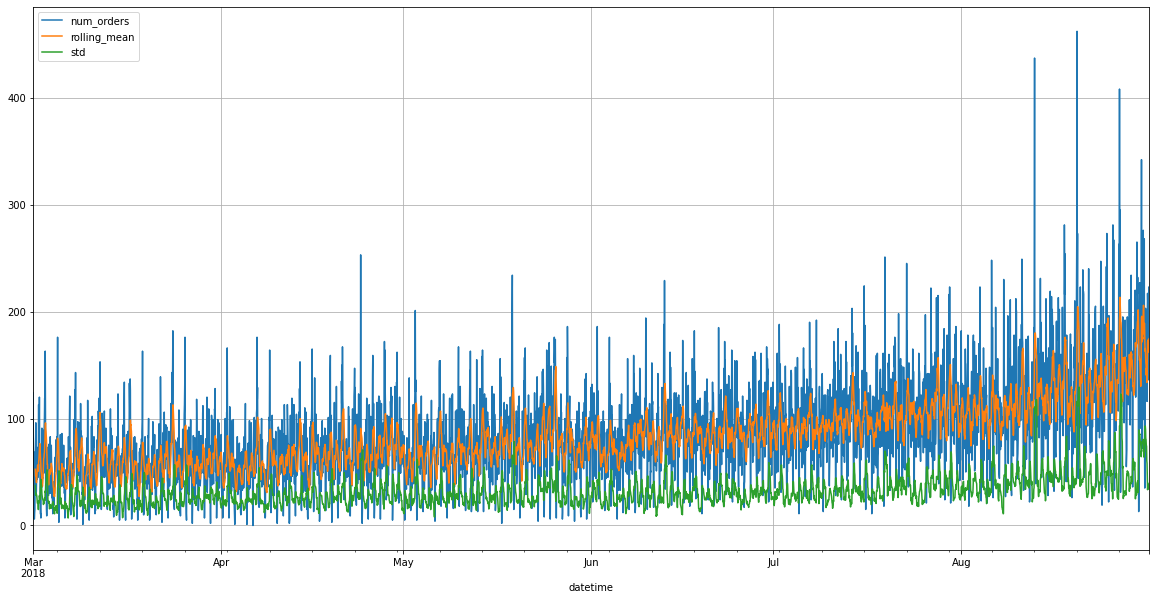

In [10]:
df['rolling_mean'] = df["num_orders"].rolling(10).mean()
df['std'] = df['num_orders'].rolling(10).std()
df.plot(figsize =(20,10), grid = True)

Для проверки на стационарность воспользуемся другими временными интервалами:

In [11]:
def get_resampled_data(data, period='1H'):
  data = data.resample(period).sum()
  data['mean'] = data['num_orders'].rolling(5).mean()
  data['std'] = data['num_orders'].rolling(5).std()
  return data

In [12]:
data_day = get_resampled_data(df, period='1D')
data_week = get_resampled_data(df, period='1W')

<AxesSubplot:xlabel='datetime'>

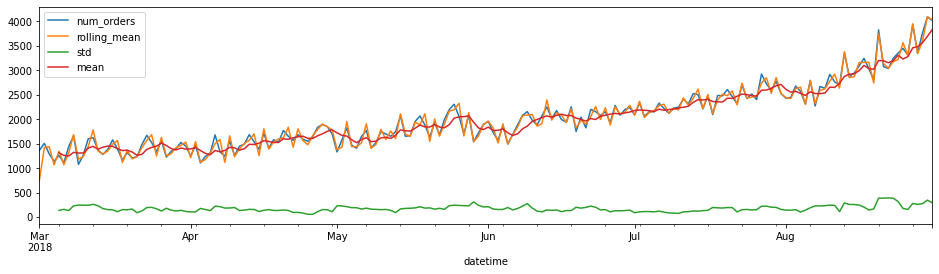

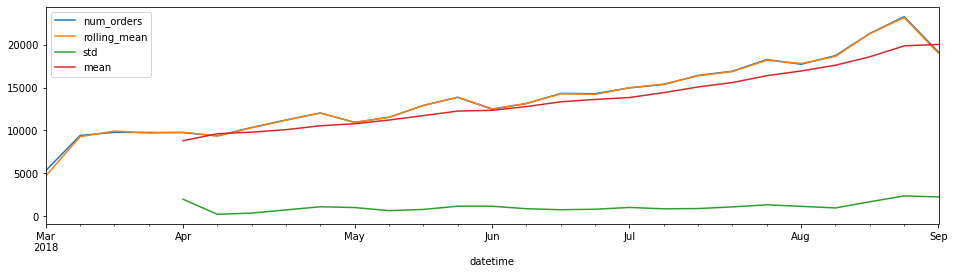

In [13]:
data_day.plot(figsize=(16, 4)) 
data_week.plot(figsize=(16, 4)) 

По графикам, постоенным для временных интервалов по дням и неделям, видно, что ряд нестационарен.

Кроме того для проверки проверки стационарности проведем обобщенный тест Дикки-Фуллера:

In [14]:
def adf(series):
  p_value = ts.adfuller(series)[1]
  print(f"p-value = {p_value}")
  if p_value > 0.05:
    print('Ряд нестационарный')
  else:
    print('Ряд стационарный')

In [15]:
adf(df['num_orders']) 

p-value = 0.028940051402612802
Ряд стационарный


In [16]:
adf(data_day['num_orders'])

p-value = 1.0
Ряд нестационарный


In [17]:
adf(data_week['num_orders'])

p-value = 0.9990561132668951
Ряд нестационарный


Видно, что стационарность зависит от временного отрезка. Будем считать, что ряд нестационарен. </br>
Чтобы сделать его стационарным - продифференцируем его:

<AxesSubplot:xlabel='datetime'>

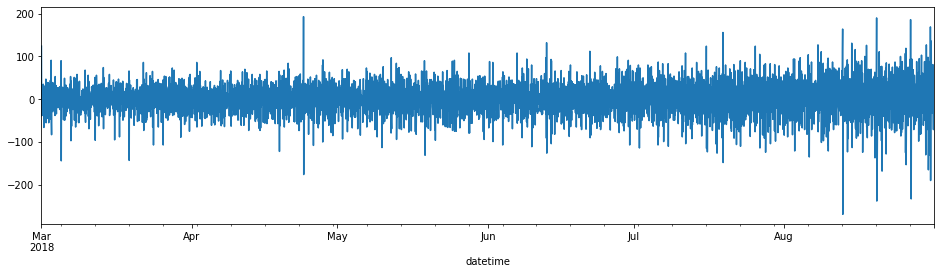

In [18]:
df_diff = df['num_orders'] - df['num_orders'].shift(fill_value=0)
df_diff.plot(figsize=(16, 4)) 

Теперь проверим его по тесту Дикки-Фуллера:

In [19]:
adf(df_diff)

p-value = 1.0915609954401705e-28
Ряд стационарный


Проанализируем временной ряд на тренд и сезонную компоненту:

In [20]:
df_diff_aug = df_diff['2018-08-01':'2018-08-30'] # для анализа возьмем один месяц

In [21]:
decomposed = seasonal_decompose(df_diff_aug) 

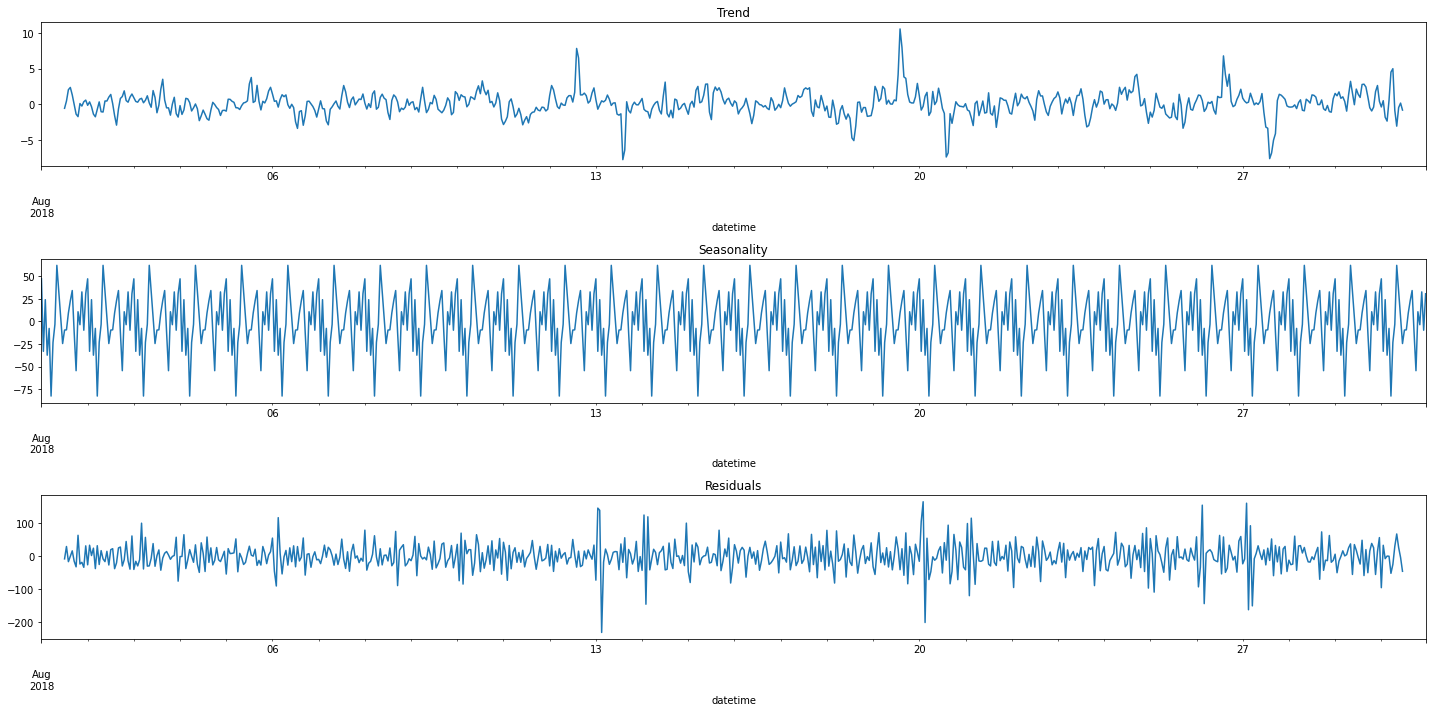

In [22]:
plt.figure(figsize=(20, 10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() 
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend') # тренд
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')  # сезонность
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals') # шум
plt.tight_layout()

 При анализе данных за месяц, из графиков видно, что тренда не наблюдается, четко видно сезонность (провалы в заказах по утрам, потом резкие скачки), равномерный шум.

## Обучение моделей

Создадим необходимые признаки, введем аргумент отставания max_lag. Введем скользящее среднее и добавим его как аргумент. 

In [23]:
df

,num_orders,rolling_mean,std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN
...,...,...,...
2018-08-31 19:00:00,136,166.6,35.362252
2018-08-31 20:00:00,154,162.9,34.449480
2018-08-31 21:00:00,159,162.1,34.436576


In [24]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    df_features = df 
    return df_features

In [25]:
df_features = make_features(df, 20, 1) # зададим параметры аргументов

In [26]:
df_features.head()

,num_orders,rolling_mean,std,year,month,day,dayofweek,lag_1,lag_2,lag_3,...,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,2018,3,1,3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,124.0,NaN,2018,3,1,3,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,85.0,NaN,2018,3,1,3,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,71.0,NaN,2018,3,1,3,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,66.0,NaN,2018,3,1,3,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобъем данные на выборки (обучающая, тестовая):

In [27]:
train, test = train_test_split(df_features, shuffle=False, test_size=0.1)
train = train.dropna()

In [28]:
features_train = train.drop(columns = ["num_orders"])
target_train = train["num_orders"]

features_test = test.drop(columns = ["num_orders"])
target_test = test["num_orders"]


In [29]:
features_train.shape

(3954, 26)

In [30]:
features_test.shape

(442, 26)

Напишем функцию для вычисления RMSE:

In [28]:
def rmse (target_test, predictions):  
    return mean_squared_error(target_test, predictions, squared=False)

Рассмотрим модель Линейная регрессия (подберем наилучшие параметры, обучим модель и получим предсказания, посчитаем RMSE):

In [29]:
model_lr = LinearRegression() 

In [30]:
parameters_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [31]:
tscv = TimeSeriesSplit(n_splits=4)
tscv

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=4, test_size=None)

In [32]:
grid_lr = GridSearchCV(model_lr, parameters_lr, cv=tscv)
grid_lr.fit(features_train, target_train)
grid_lr.best_params_

C:\Users\Nela\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
C:\Users\Nela\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous beha

{'copy_X': True, 'fit_intercept': True, 'normalize': False}

In [33]:
model_lr = LinearRegression(fit_intercept = False, normalize = True, copy_X = True)
model_lr.fit(features_train, target_train)

C:\Users\Nela\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


LinearRegression(fit_intercept=False, normalize=True)

In [34]:
predictions = model_lr.predict(features_test)
rmse_lr = rmse(target_test, predictions)
print("Среднеквадратическая ошибка модели методом Линейная регрессия: : ", rmse_lr)

Среднеквадратическая ошибка модели методом Линейная регрессия: :  55.222259115904215


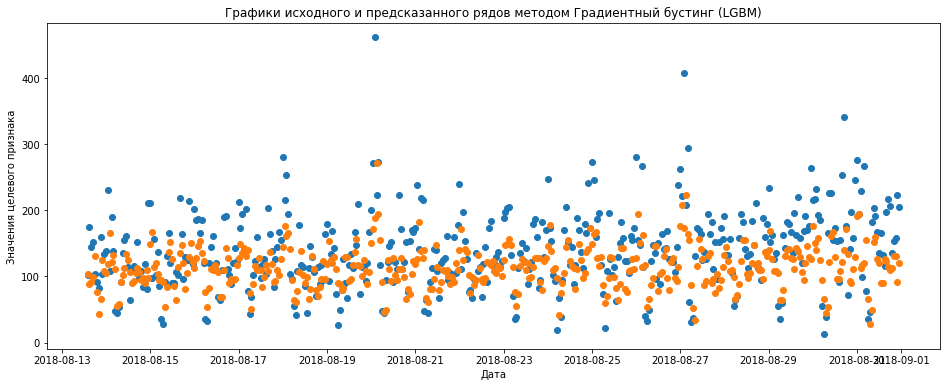

In [35]:
fig, ax = plt.subplots()
plt.scatter(x = target_test.index, y = target_test)
plt.scatter(x = target_test.index, y = predictions)
plt.title("Графики исходного и предсказанного рядов методом Градиентный бустинг (LGBM)")
plt.ylabel("Значения целевого признака")
plt.xlabel("Дата")
fig.set_figwidth(16)     #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.show()

Рассмотрим на модели Дерево решений: 

In [36]:
model_tree = DecisionTreeRegressor()

In [37]:
parametrs_tr = { 'max_depth': range (1,13, 1), # глубина дерева от 1 до 13 с шагом 1
             'min_samples_leaf': range (1, 8),
              'min_samples_split': range (2,20,2)
              }

In [38]:
# grid_tr = GridSearchCV(model_tree, parametrs_tr, cv=tscv) # Очень долго считаются параметры, сразу подставим посчитанные значения
# grid_tr.fit(features_train, target_train)
# grid_tr.best_params_ #  'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 18

In [39]:
model_tree = DecisionTreeRegressor(random_state = 12345, max_depth = 4, min_samples_leaf = 4, min_samples_split = 18)
model_tree.fit(features_train, target_train) # обучим

predictions_tree = model_tree.predict(features_test)

rmse_tree = rmse(target_test, predictions_tree)
print("Среднеквадратическая ошибка модели методом Дерево решений: ", rmse_tree)


Среднеквадратическая ошибка модели методом Дерево решений:  62.18762382561048


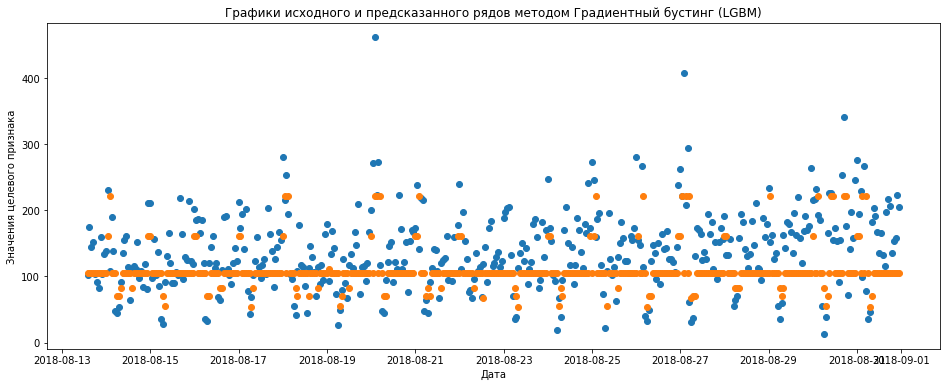

In [40]:
fig, ax = plt.subplots()
plt.scatter(x = target_test.index, y = target_test)
plt.scatter(x = target_test.index, y = predictions_tree)
plt.title("Графики исходного и предсказанного рядов методом Градиентный бустинг (LGBM)")
plt.ylabel("Значения целевого признака")
plt.xlabel("Дата")
fig.set_figwidth(16)     #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.show()

На модели Градиентный бустинг (LGBM):

In [41]:
scoring_fit = 'neg_mean_squared_error'

In [42]:
model_lgbm = LGBMRegressor(random_state = 54321)

In [43]:
param_grid = {'n_estimators': [50, 1000], 'max_depth': [5, 10, 12]}

In [44]:
gs = GridSearchCV(model_lgbm, param_grid, cv = tscv, scoring = scoring_fit)

In [45]:
gs.fit(features_train, target_train)
gs.best_params_

{'max_depth': 12, 'n_estimators': 50}

In [50]:
model_lgbm_optim = LGBMRegressor(random_state = 54321, max_depth = 12, n_estimators = 50)
model_lgbm_optim.fit(features_train, target_train)
predictions_lgbm = model_lgbm_optim.predict(features_test)

In [51]:
rmse_lgbm = rmse(target_test, predictions_lgbm)
print("Среднеквадратическая ошибка модели Градиентный бустинг методом LGBM: ", rmse_lgbm)

Среднеквадратическая ошибка модели Градиентный бустинг методом LGBM:  48.14718139498798


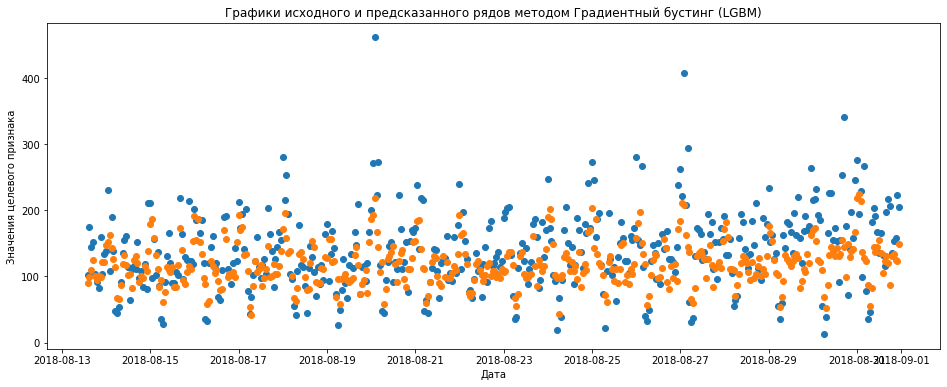

In [52]:
fig, ax = plt.subplots()
plt.scatter(x = target_test.index, y = target_test)
plt.scatter(x = target_test.index, y = predictions_lgbm)
plt.title("Графики исходного и предсказанного рядов методом Градиентный бустинг (LGBM)")
plt.ylabel("Значения целевого признака")
plt.xlabel("Дата")
fig.set_figwidth(16)     #  ширина и
fig.set_figheight(6)    #  высота "Figure"
plt.show()

## Анализ моделей

In [49]:
rez = pd.DataFrame({"модель": ["Линейная регрессия", "Дерево решений", 
                              "Градиентный бустинг (LGBM)"], "значение RMSE": [rmse_lr, rmse_tree, rmse_lgbm]})
rez

,модель,значение RMSE
0,Линейная регрессия,55.222259
1,Дерево решений,62.187624
2,Градиентный бустинг (LGBM),47.867227


## Вывод

Модели прогнозирования количества заказов такси на следующий час построены. </br>
Из таблицы анализа видно, что лучший результат значения среднеквадратической ошибки предсказания показывает модель Градиентного бустинга (LightGBM).

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48